In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import matplotlib.ticker as mticker

import seaborn
seaborn.set_context('talk')

from sqlalchemy import create_engine, text

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2025*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [2]:
import plotly
plotly.__version__


'5.22.0'

In [3]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

airbnb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')

C:\Users\rbarone\AppData\Local\Temp\ipykernel_28156\590215205.py:4: DtypeWarning: Columns (35,77) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pandas.read_csv(


## Ejercicio 1 SQL:

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite

2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

3. Validar tipos de columnas antes de guardar: df.to_sql() infiere tipos automáticamente, pero a veces los nombres de columnas como Date, Price o ID dan problemas si vienen con strings o valores nulos.

4. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.
    - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
    - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.

5. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.  



Creacion de Base de datos e ingesta

In [4]:
engine = create_engine("sqlite:///C:\\diplomatura\\to\\melbourne.db", echo=True)
# engine

melb_df.to_sql('melb', con=engine, if_exists='replace', index=False)

airbnb_df['zipcode'] = pandas.to_numeric( airbnb_df.zipcode, errors='coerce')
insertPriceAndZipcode = airbnb_df[['weekly_price','monthly_price', 'zipcode']].dropna()
insertPriceAndZipcode.to_sql('airbnb', con=engine, if_exists='replace', index=False)

airbnb_df.to_sql('airbnbAll', con=engine, if_exists='replace', index=False)
airbnb_df

2025-05-21 22:25:57,219 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:25:57,229 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-21 22:25:57,230 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:25:57,232 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-21 22:25:57,233 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:25:57,235 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-21 22:25:57,238 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:25:57,241 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-21 22:25:57,242 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:25:57,244 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("melb")
2025-05-21 22:25:57,245 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:25:57,2

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,...,review_scores_location,review_scores_value,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,9835,https://www.airbnb.com/rooms/9835,2.018120e+13,12/7/2018,Beautiful Room & House,NaN,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,NaN,...,9.0,9.0,f,NaN,f,strict_14_with_grace_period,f,f,1,0.04
1,10803,https://www.airbnb.com/rooms/10803,2.018120e+13,12/7/2018,Room in Cool Deco Apartment in Brunswick,A large air conditioned room with queen spring...,The apartment is Deco/Edwardian in style and h...,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,NaN,...,9.0,9.0,f,NaN,t,moderate,t,t,1,1.50
2,12936,https://www.airbnb.com/rooms/12936,2.018120e+13,12/7/2018,St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,FREE WiFi FREE in-building remote controlled g...,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,First floor apartment with both lift and stair...,...,9.0,9.0,f,NaN,f,strict_14_with_grace_period,f,f,17,0.15
3,15246,https://www.airbnb.com/rooms/15246,2.018120e+13,12/7/2018,Large private room-close to city,"Comfortable, relaxed house, a home away from ...",The atmosphere is relaxed and easy going. You ...,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...",A simple self service breakfast is available –...,...,9.0,9.0,f,NaN,f,moderate,f,f,3,0.30
4,16760,https://www.airbnb.com/rooms/16760,2.018120e+13,12/7/2018,Melbourne BnB near City & Sports,NaN,We offer comfortable accommodation in Inner Me...,We offer comfortable accommodation in Inner Me...,NaN,NaN,...,10.0,9.0,f,NaN,f,moderate,f,f,1,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22890,30592332,https://www.airbnb.com/rooms/30592332,2.018120e+13,12/7/2018,lovely home,"near city, near tram station",NaN,"near city, near tram station",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,1,NaN
22891,30592345,https://www.airbnb.com/rooms/30592345,2.018120e+13,12/7/2018,Melton South Getaway,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,2,NaN
22892,30592362,https://www.airbnb.com/rooms/30592362,2.018120e+13,12/7/2018,"Glen Waverley(close to train, post, stores)近地铁...","Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",NaN,"Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,1,NaN
22893,30592590,https://www.airbnb.com/rooms/30592590,2.018120e+13,12/7/2018,Crown Jewel in the heart of Melbourne,Immaculately presented and carefully maintaine...,Security is a focus with intercom-activated en...,Immaculately presented and carefully maintaine...,A plethora of Melbourne highlights are just a ...,NaN,...,NaN,NaN,f,NaN,t,moderate,f,f,17,NaN


In [5]:
query="select * from melb"

result = pandas.read_sql_query(query, engine)
result

2025-05-21 22:26:02,441 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:02,442 INFO sqlalchemy.engine.Engine select * from melb
2025-05-21 22:26:02,444 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,702 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,None,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,None,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,None,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,None,-37.85908,144.89299,Western Metropolitan,6380.0


In [6]:
queryTotalRegistrosPorCiudad = "select count(*) as total, regionname from melb group by Regionname order by total desc;"
resultTotalRegistrosPorCiudad = pandas.read_sql(queryTotalRegistrosPorCiudad, con=engine)
resultTotalRegistrosPorCiudad


2025-05-21 22:26:02,815 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:02,817 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, regionname from melb group by Regionname order by total desc;")
2025-05-21 22:26:02,818 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,819 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, regionname from melb group by Regionname order by total desc;")
2025-05-21 22:26:02,820 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,821 INFO sqlalchemy.engine.Engine select count(*) as total, regionname from melb group by Regionname order by total desc;
2025-05-21 22:26:02,822 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,835 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Regionname
0,4695,Southern Metropolitan
1,3890,Northern Metropolitan
2,2948,Western Metropolitan
3,1471,Eastern Metropolitan
4,450,South-Eastern Metropolitan
5,53,Eastern Victoria
6,41,Northern Victoria
7,32,Western Victoria


In [7]:

queryTotalRegistrosPorBarrioYCiudad = "select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;"
resultTotalRegistrosPorBarrioYCiudad = pandas.read_sql(queryTotalRegistrosPorBarrioYCiudad, con=engine)
resultTotalRegistrosPorBarrioYCiudad

2025-05-21 22:26:02,857 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:02,859 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;")
2025-05-21 22:26:02,859 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,861 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;")
2025-05-21 22:26:02,861 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,862 INFO sqlalchemy.engine.Engine select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;
2025-05-21 22:26:02,863 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,886 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Suburb
0,359,Reservoir
1,260,Richmond
2,249,Bentleigh East
3,239,Preston
4,222,Brunswick
...,...,...
309,1,Sandhurst
310,1,Plumpton
311,1,Rockbank
312,1,Bacchus Marsh


In [8]:
    # - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    
queryTotalRegistrosPorCiudadConMasDe2Habitaciones = "select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;"
resultTotalRegistrosPorCiudadConMasDe2Habitaciones = pandas.read_sql(queryTotalRegistrosPorCiudadConMasDe2Habitaciones, con=engine)
resultTotalRegistrosPorCiudadConMasDe2Habitaciones


2025-05-21 22:26:02,928 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:02,930 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;")
2025-05-21 22:26:02,931 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,932 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;")
2025-05-21 22:26:02,933 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,934 INFO sqlalchemy.engine.Engine select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;
2025-05-21 22:26:02,936 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,945 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Regionname
0,2848,Southern Metropolitan
1,2389,Northern Metropolitan
2,2259,Western Metropolitan
3,1228,Eastern Metropolitan
4,407,South-Eastern Metropolitan
5,50,Eastern Victoria
6,39,Northern Victoria
7,31,Western Victoria


In [9]:
    # - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
queryPrecioPromedioPorTipoYCiudad = "select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;"
resultPrecioPromedioPorTipoYCiudad = pandas.read_sql(queryPrecioPromedioPorTipoYCiudad, con=engine)
resultPrecioPromedioPorTipoYCiudad

2025-05-21 22:26:02,968 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:02,969 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;")
2025-05-21 22:26:02,970 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,972 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;")
2025-05-21 22:26:02,972 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:02,974 INFO sqlalchemy.engine.Engine select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;
2025-05-21 22:26:02,975 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:03,000 INFO sqlalchemy.engine.Engine ROLLBACK


,precio_promedio,Type,Regionname
0,1802241.08,h,Southern Metropolitan
1,1205404.47,t,Southern Metropolitan
2,1197450.46,h,Eastern Metropolitan
3,1021221.87,h,Northern Metropolitan
4,955949.62,h,South-Eastern Metropolitan
5,950766.27,h,Western Metropolitan
6,913270.00,t,South-Eastern Metropolitan
7,869619.92,t,Eastern Metropolitan
8,749608.31,t,Northern Metropolitan
9,720951.05,t,Western Metropolitan


In [10]:
    # - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.
queryTop5BarriosConPropiedadesMasCaras = "select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;"
resultTop5BarriosConPropiedadesMasCaras = pandas.read_sql(queryTop5BarriosConPropiedadesMasCaras, con=engine)
resultTop5BarriosConPropiedadesMasCaras


2025-05-21 22:26:03,026 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:03,027 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-21 22:26:03,028 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:03,029 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-21 22:26:03,029 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:03,031 INFO sqlalchemy.engine.Engine select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;
2025-05-21 22:26:03,031 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:03,047 INFO sqlalchemy.engine.Engine ROLLBACK


,precio_promedio,Suburb
0,2185000.00,Kooyong
1,2180240.74,Canterbury
2,2082529.41,Middle Park
3,1941355.07,Albert Park
4,1930158.00,Brighton


Ejercicio 5

In [11]:
queryJoin = "select m.*, a.price as PriceAirBnb, a.weekly_price, a.monthly_price, a.zipcode from melb m left join airbnbAll a on m.postcode = a.zipcode"
resultJoin = pandas.read_sql(queryJoin, con=engine)
resultJoin

2025-05-21 22:26:03,072 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:03,073 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.price as PriceAirBnb, a.weekly_price, a.monthly_price, a.zipcode from melb m left join airbnbAll a on m.postcode = a.zipcode")
2025-05-21 22:26:03,074 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:03,076 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.price as PriceAirBnb, a.weekly_price, a.monthly_price, a.zipcode from melb m left join airbnbAll a on m.postcode = a.zipcode")
2025-05-21 22:26:03,076 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:03,078 INFO sqlalchemy.engine.Engine select m.*, a.price as PriceAirBnb, a.weekly_price, a.monthly_price, a.zipcode from melb m left join airbnbAll a on m.postcode = a.zipcode
2025-05-21 22:26:03,079 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:26,825 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,PriceAirBnb,weekly_price,monthly_price,zipcode
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,28.0,NaN,NaN,3067.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,30.0,NaN,NaN,3067.0
2,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,30.0,180.0,700.0,3067.0
3,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,30.0,180.0,700.0,3067.0
4,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,30.0,180.0,700.0,3067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2139679,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,285.0,1995.0,7000.0,3013.0
2139680,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,289.0,1700.0,3900.0,3013.0
2139681,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,300.0,NaN,NaN,3013.0
2139682,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,480.0,NaN,NaN,3013.0


## Ejercicio 2 - Pandas:

1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.
  1. Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
  2.  Mostrar la dispersión o distribución de las columnas seleccionadas.
 3.  Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.
 4. Mostrar visualmente los valores extremos que eliminás



2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
  2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  3. Mostrar un gráfico zipcode vs airbnb_price_median.
  4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
  5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

¿Qué cosas no están en los datos que te gustaría tener para predecir mejor el precio de una propiedad?

In [12]:
#1 -Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.

#Vamos a utilizar la columnas Price, Rooms, Bedroom2 y bathroom ya que tienen una buena correlacion con el precio de las propiedades
queryEjercicio2 = "select * from melb"
resultCorrelacion = pandas.read_sql_query(queryEjercicio2, engine).select_dtypes(include=[numpy.number]).corr().abs()
resultCorrelacion['Price'].sort_values(ascending=False)


2025-05-21 22:26:29,318 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:29,320 INFO sqlalchemy.engine.Engine select * from melb
2025-05-21 22:26:29,321 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:29,448 INFO sqlalchemy.engine.Engine ROLLBACK


Price            1.000000
Rooms            0.496634
Bedroom2         0.475951
Bathroom         0.467038
YearBuilt        0.323617
Car              0.238979
Lattitude        0.212934
Longtitude       0.203656
Distance         0.162522
Postcode         0.107867
BuildingArea     0.090981
Propertycount    0.042153
Landsize         0.037507
Name: Price, dtype: float64

In [13]:
melb_df.groupby('Regionname').agg(
    total=('Price', 'count'),
    precio_promedio=('Price', 'mean'),
    precio_median=('Price', 'median'),
    precio_max=('Price', 'max'),
    precio_min=('Price', 'min')
).reset_index().sort_values('total', ascending=False)

,Regionname,total,precio_promedio,precio_median,precio_max,precio_min
5,Southern Metropolitan,4695,1.372963e+06,1250000.0,8000000.0,131000.0
2,Northern Metropolitan,3890,8.981711e+05,806250.0,4525000.0,145000.0
6,Western Metropolitan,2948,8.664205e+05,793000.0,3900000.0,85000.0
0,Eastern Metropolitan,1471,1.104080e+06,1010000.0,4000000.0,288000.0
4,South-Eastern Metropolitan,450,9.229438e+05,850000.0,9000000.0,266000.0
1,Eastern Victoria,53,6.999808e+05,670000.0,1085000.0,400000.0
3,Northern Victoria,41,5.948293e+05,540000.0,1355000.0,330000.0
7,Western Victoria,32,3.975234e+05,400000.0,710000.0,280500.0


In [14]:
# Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
quereSelectedColumns = "select Price, Rooms, Bedroom2, Bathroom  from melb"
rows = pandas.read_sql(quereSelectedColumns, con=engine)

totalValorFaltante = 0

for idx, fila in rows.iterrows():
    if fila.isnull().any():
        totalValorFaltante += 1
        continue

print(f"\nTotal de filas con al menos un valor faltante en su columna: {totalValorFaltante / len(rows) * 100:.2f}%")

rows.info()

2025-05-21 22:26:29,515 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:29,516 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select Price, Rooms, Bedroom2, Bathroom  from melb")
2025-05-21 22:26:29,516 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:29,518 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select Price, Rooms, Bedroom2, Bathroom  from melb")
2025-05-21 22:26:29,518 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:29,519 INFO sqlalchemy.engine.Engine select Price, Rooms, Bedroom2, Bathroom  from melb
2025-05-21 22:26:29,522 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:29,563 INFO sqlalchemy.engine.Engine ROLLBACK

Total de filas con al menos un valor faltante en su columna: 0.00%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     13580 non-null  float64
 1   

In [15]:
columnasSeleccionadas = ['Price', 'Rooms', 'Bedroom2', 'Bathroom']
result = pandas.read_sql(queryEjercicio2, con=engine)[columnasSeleccionadas]

result.sort_values(by='Price', ascending=True)


2025-05-21 22:26:30,322 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:30,323 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select * from melb")
2025-05-21 22:26:30,324 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:30,326 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select * from melb")
2025-05-21 22:26:30,327 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:30,327 INFO sqlalchemy.engine.Engine select * from melb
2025-05-21 22:26:30,328 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:30,432 INFO sqlalchemy.engine.Engine ROLLBACK


,Price,Rooms,Bedroom2,Bathroom
2652,85000.0,1,1.0,1.0
1805,131000.0,4,4.0,1.0
7303,145000.0,1,2.0,1.0
1927,145000.0,4,3.0,1.0
7940,160000.0,1,1.0,1.0
...,...,...,...,...
12557,6400000.0,5,5.0,2.0
3616,6500000.0,6,6.0,6.0
9575,7650000.0,4,4.0,2.0
7692,8000000.0,5,5.0,5.0


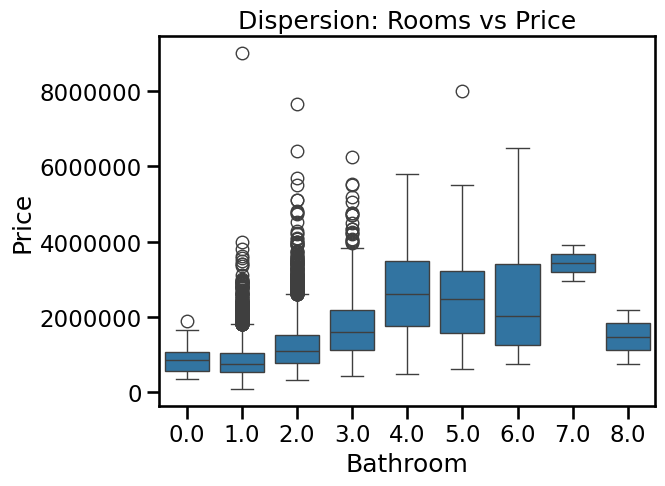

In [16]:
# 2.  Mostrar la dispersión o distribución de las columnas seleccionadas.

ax = seaborn.boxplot(x='Bathroom', y='Price', data=result)
plt.title('Dispersion: Rooms vs Price')

ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

plt.show()

2025-05-21 22:26:30,960 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-21 22:26:30,960 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1800000.0")
2025-05-21 22:26:30,961 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:30,962 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1800000.0")
2025-05-21 22:26:30,964 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:30,964 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1800000.0


2025-05-21 22:26:30,966 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-21 22:26:32,698 INFO sqlalchemy.engine.Engine ROLLBACK


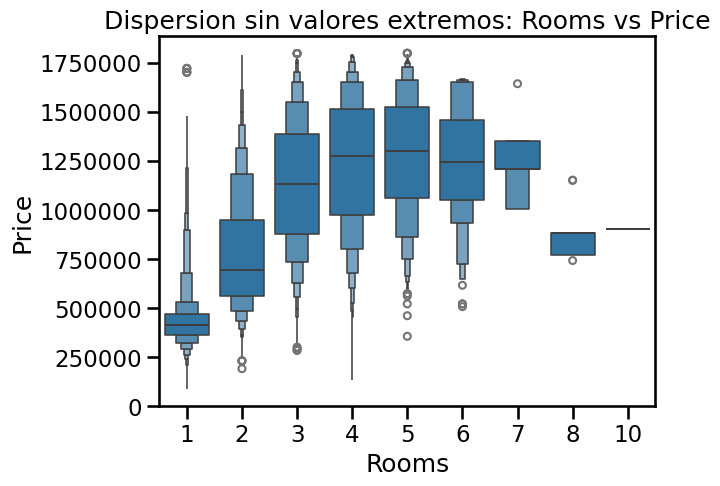

In [17]:
#Eliminar valores atípicos de propiedades con valores mayor a 6 millone

pandas.set_option('display.float_format', lambda x: '%.2f' % x)
quantile=  resultJoin['Price'].quantile(0.90)


queryJoin = "select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < "+ str(quantile)    

resultJoin = pandas.read_sql(queryJoin, con=engine)

ax = seaborn.boxenplot(x='Rooms', y='Price', data=resultJoin)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

plt.title('Dispersion sin valores extremos: Rooms vs Price')
plt.show()

In [18]:
resultJoin.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'weekly_price',
       'monthly_price'],
      dtype='object')

2025-05-22 00:38:03,553 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-22 00:38:03,555 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000")
2025-05-22 00:38:03,555 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-22 00:38:03,556 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000")
2025-05-22 00:38:03,558 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-22 00:38:03,559 INFO sqlalchemy.engine.Engine select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000
2025-05-22 00:38:03,560 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-22 00:38:03,723 INFO sqlalchemy.engine.Engine ROLLBACK
2025-05-22 00:38:03,725 INFO sqlalchemy.engine.Engin

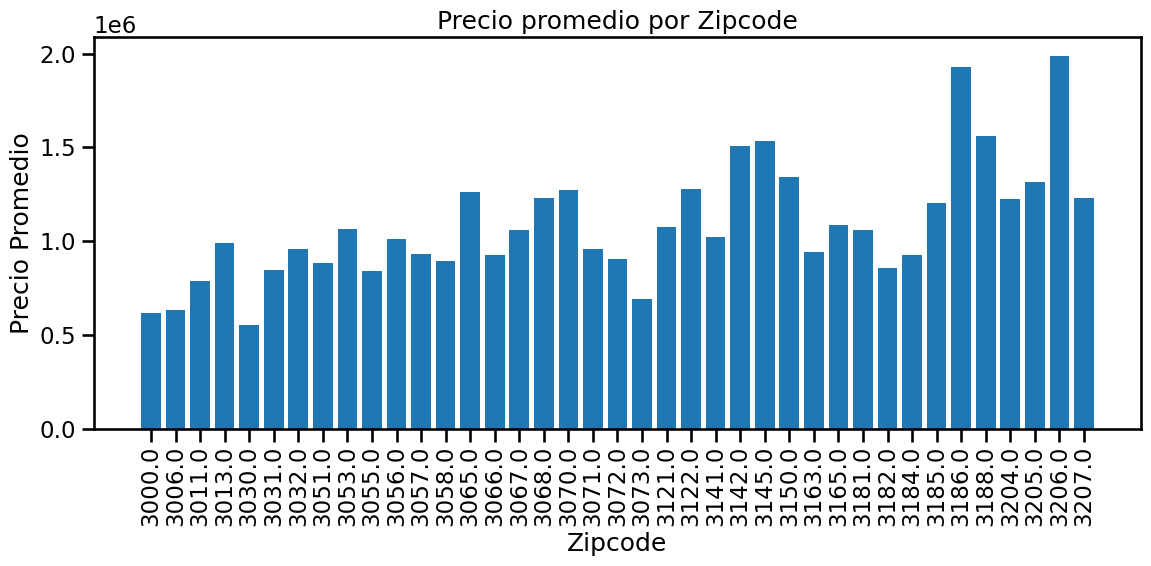

In [44]:
# Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
#   1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
#   2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
#   3. Mostrar un gráfico zipcode vs airbnb_price_median. ()
#   4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
#   5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?

queryZipCode = "select a.zipcode, count(*) as total from airbnb a inner join melb m on a.zipcode = m.Postcode group by a.zipcode having total > 1000"
resultJoin = pandas.read_sql(queryZipCode, con=engine)
zipcodes = resultJoin['zipcode'].tolist()
zipcodes

queryZipCodeClear = "select * from melb m inner join airbnb a on a.zipcode = m.Postcode where a.zipcode in (" + ','.join(map(str, zipcodes)) + ")"	
resultqueryZipCodeClear = pandas.read_sql(queryZipCodeClear, con=engine)
resultqueryZipCodeClear

# resultqueryZipCodeClear.groupby('zipcode').agg(
#     total=('Price', 'count'),
#     precio_promedio=('Price', 'mean'),
#     precio_median=('Price', 'median')
# ).reset_index().sort_values('total', ascending=False)

df_zipcode = resultqueryZipCodeClear.groupby('zipcode', as_index=False)['Price'].mean().rename(columns={'Price': 'precio_promedio'})

plt.figure(figsize=(12, 6))
plt.bar(df_zipcode['zipcode'].astype(str), df_zipcode['precio_promedio'])
plt.xlabel('Zipcode')
plt.ylabel('Precio Promedio')
plt.title('Precio promedio por Zipcode')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
airbnb_df.groupby('zipcode').agg(
    total=('Price', 'count'),
    precio_promedio=('Price', 'mean'),
    precio_median=('Price', 'median')
).reset_index().sort_values('total', ascending=False)

## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

## Ejercicios opcionales:

1. Armar un script en python (archivo .py) [ETL](https://towardsdatascience.com/what-to-log-from-python-etl-pipelines-9e0cfe29950e) que corra los pasos de extraccion, transformacion y carga, armando una funcion para cada etapa del proceso y luego un main que corra todos los pasos requeridos.

2. Armar un DAG en Apache Airflow que corra el ETL. (https://airflow.apache.org/docs/apache-airflow/stable/tutorial.html)

In [ ]:
import pandas as pd
import datetime as dt
import requests
import io
from sqlalchemy import create_engine, text
import os
#from decouple import config
import logging

In [ ]:
# En lugar de usar prints para ver el avance a medida que va corriendo el script se utilizan los logs.
# Los logs basicamente son registros que se van dejando para saber el codigo que ha sido ejecutado.
# Es decision arbitraria del programador decidir que desea registrar en los logs.
# En python se utiliza la libreria logging https://docs.python.org/3/library/logging.html#logging-levels
# La libreria permite definir niveles de logs (ERROR, DEBUG, INFO, etc). Segun la criticidad del error.
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [ ]:

def extract(url,interesting_cols):
  # The extract process could be complex including some SQL queries
    if len(interesting_cols) ==0:
        df = pd.read_csv(url)
        logger.info('read_csv exitoso')
    else:
        df = pd.read_csv(url,usecols=interesting_cols)
        logger.info('read_csv exitoso con columnas interesantes')
    return df

def connection_db(database_name):
    '''Connect to DB using SQLAlchemy methods. Returns an engine created and connected'''
    try:
        engine = create_engine(f"sqlite:///{database_name}", echo=True)
        logger.info('Conexion exitosa a la base de datos')
        return engine

    except ValueError as e:
        logger.error(e)


def transform(df,database_table_name):
  '''Transform the data. In this case, we are going to use the same dataframe'''
  # En este caso no se realizan transformaciones
  # pero se pueden realizar transformaciones como eliminar columnas, renombrar columnas, etc.
  if database_table_name == 'melb'
    melb_df['Postcode'] = pd.to_numeric(melb_df.Postcode, errors='coerce')
    melb_df['Postcode_int'] = melb_df.Postcode.fillna(0).astype('int') # Convertimos la columna Postcode a int y renombramos la columna para no perder la original
    melb_df['Date'] = pd.to_datetime(melb_df['Date'], errors='coerce') # Convertimos la columna Date a datetime
    melb_df['Bedroom2'] = melb_df['Bedroom2'].fillna(0).astype('int') # Convertimos la columna Bedroom2 a int
    melb_df['Bathroom'] = melb_df['Bathroom'].fillna(0).astype('int') # Convertimos la columna Bathroom a int
    melb_df['Car'] = melb_df['Car'].fillna(0).astype('int') # Convertimos la columna Car a int
  else:
    # Working data for the analysis
    airbnb_df['zipcode'] = pd.to_numeric(airbnb_df.zipcode, errors='coerce')
    airbnb_df['zipcode_int'] = airbnb_df.zipcode.fillna(0).astype('int') # Convertimos la columna zipcode a int y renombramos la columna para no perder la original
    airbnb_df['weekly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*7. if pd.isnull(row['weekly_price']) else row['weekly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*7dias
    airbnb_df['monthly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*30. if pd.isnull(row['monthly_price']) else row['monthly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*30dias


def save_database(df,table_name):
  '''Load the data into the database'''
  try:
      # Create a table 'melb' in the SQLite database
      df.to_sql(table_name, con=engine, if_exists='replace', index=False)
      logger.info('Carga exitosa de la tabla en la base de datos')
  except ValueError as e:
      logger.error(e)
      logger.error('Error en la carga de la tabla en la base de datos')
    

In [ ]:
# la funcion main es muy utilizada en scripts python cuando tenemos archivos .py por ejemplo etl.py
# al tener la funcion main pueden correr desde la terminal python etl.py y va a ejecutar lo definido en la funcion main
def main_etl():
    logger.info('Comienza la extraccion')
    logger.info('Conectar a la base de datos')
    engine = connection_db('melbourne.db')
    logger.info('Extract data from url melbourne dataset')
    df = extract('http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv', [])
    logger.info('Transform data')
    transform(df,'melb')
    logger.info('Save data into database')
    save_database(df,engine,'melb')
    logger.info('Extract data from url airbnb dataset')
    df = extract('http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv', ['description', 'neighborhood_overview','street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode','price', 'weekly_price', 'monthly_price','latitude', 'longitude'])
    logger.info('Transform data')
    transform(df,'airbnb')
    logger.info('Save data into database')
    save_database(df,'airbnb')

if __name__ == "__main_etl__":
    logger.info('ETL Process Initialized')
    main_etl()

In [ ]:
# ejemplo de DAG en Airflow for melb ETL dataset
from airflow import DAG
with DAG(
    'dag_melb',
    default_args=default_args,
    description='DAG ',
    schedule_interval=timedelta(hours=1),
    start_date=datetime(2025, 6, 26),
) as dag:
    connection = PythonOperator(task_id='engine',
                                python_callable=connection_db(),
                                op_kwargs={database_name: 'melbourne.db'},)
    extraction = PythonOperator(task_id='engine',
                                python_callable=extract(),
                                op_kwargs={url:'http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv',interesting_cols:[]},)
    transformation = PythonOperator(task_id='transformation',
                                    python_callable=transform
                                    op_kwargs={database_table_name: 'melb')
    save_database = PythonOperator(task_id='save_database',
                                 python_callable=save_database,
                                 op_kwargs={table_name:'melb'},)
    connection >> extraction >> transformation >> save_database

# ejemplo de DAG en Airflow for airbnb ETL dataset
from airflow import DAG
with DAG(
    'dag_airbnb',
    default_args=default_args,
    description='DAG ',
    schedule_interval=timedelta(hours=1),
    start_date=datetime(2025, 6, 26),
) as dag:
    connection = PythonOperator(task_id='engine',
                                python_callable=connection_db(),
                                op_kwargs={database_name: 'melbourne.db'},)
    extraction = PythonOperator(task_id='engine',
                                python_callable=extract(),
                                op_kwargs={
                                    url:'http://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
                                    interesting_cols:['description', 'neighborhood_overview','street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode','price', 'weekly_price', 'monthly_price','latitude', 'longitude']},)
    transformation = PythonOperator(task_id='transformation',
                                    python_callable=transform
                                    op_kwargs={database_table_name: 'airbnb')
    save_database = PythonOperator(task_id='save_database',
                                 python_callable=save_database,
                                 op_kwargs={table_name:'airbnb'},)
    connection >> extraction >> transformation >> save_database